## **Análise Exploratória e Pré-processamento dos Dados**
Aqui serão realizadas análises preliminares dos dados, como estatísticas, decomposição para análise de tendência, sazonalidade e resíduo das séries. Posteriormente, os dados serão separados em treino e teste para as próximas etapas do projeto: **_engenharia de características_**, **_modelagem_** e **_comparação dos resultados_**.

In [1]:
# preparação do notebook
# confirgurando diretório
import sys
import os
sys.path.append(os.path.abspath('..'))

import pandas as pd
import numpy as np
from utilsforecast.preprocessing import fill_gaps

# módulos locais
from src.features import decompose
from src.outliers import detect_outliers
from src.plots import plot_time_series, plot_time_series_acf
from src.utils import ts_train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
import warnings 

pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.filterwarnings('ignore')

# configuração de estilo
sns.set_theme(context='paper')
plt.rcParams["figure.dpi"] = 150


%load_ext autoreload
%autoreload 2

In [2]:
# leitura dos dados brutos
df = pd.read_csv(
    "data/data.csv",
    sep=';', 
    parse_dates=['ds'],
    dayfirst=True,
    dtype={'y': np.int32}
)

**NOTA:** Um passo muito importante para trabalhar com séries temporais é garantir que os dados tenham continuidade na frequência de captura das informações. Nos dados do projeto, a frequência de armazenamento é diária, logo, precisamos garantir que todos os dias situados entre **$t_0$** e **$t_n$** estejam presentes, mesmo que não tenha sido captado nenhum dado para alguns períodos. \
Por exemplo: Em dias que nenhuma venda é registrada para algum produto, alguns bancos de dados não tratão a unidade amostral correspondente para aquele dia, mas para fins de modelagem, esse dia deve estar registrado com zero, pois é um evento de interesse.

In [3]:
# preenchendo os dados com os dias ausentes
df = fill_gaps(
    df=df,
    freq='D',
    start='per_serie',
    end='per_serie'
).fillna(0)

In [4]:
# estatísticas descritivas
df.groupby("unique_id")['y'].describe()

count   mean     std  min    25%    50%     75%      max
unique_id                                                           
SKU_01    1696.00 169.23  156.41 0.00  28.00 114.50  298.00   752.00
SKU_02    2088.00 271.55  205.25 0.00  66.00 265.00  431.00  1350.00
SKU_03    2087.00  61.27   48.56 0.00  15.00  53.00  102.00   242.00
SKU_04    2088.00  47.15   35.64 0.00  11.00  51.00   75.00   406.00
SKU_05    2087.00 399.31  359.03 0.00  67.50 357.00  605.00  1850.00
SKU_06    2087.00  40.24   35.62 0.00   8.00  37.00   61.00   381.00
SKU_07    2088.00 675.27 1118.08 0.00 127.75 590.00 1011.25 40252.00
SKU_08    2088.00  76.23   61.00 0.00  17.00  75.00  122.00   478.00
SKU_09    2087.00  79.84   70.98 0.00  13.00  81.00  116.00  1008.00
SKU_10    2087.00  26.91   24.50 0.00   6.00  25.00   39.00   247.00
SKU_11    2088.00 403.49  327.42 0.00 108.00 335.50  630.25  1594.00
SKU_12    2088.00  81.45   55.58 0.00  22.00  88.00  126.00   257.00
SKU_13    2088.00 266.99  280.04 0.00  53.00 187.00  401.00  3120.00
SKU_14    2088.00  71.08   57.73 0.00  14.00  77.00  107.00  1073.00
SKU_15    2088.00 241.91  216.79 0.00  54.00 211.50  366.25  2469.00

## **Visualização dos Dados**

### **Séries Completas**

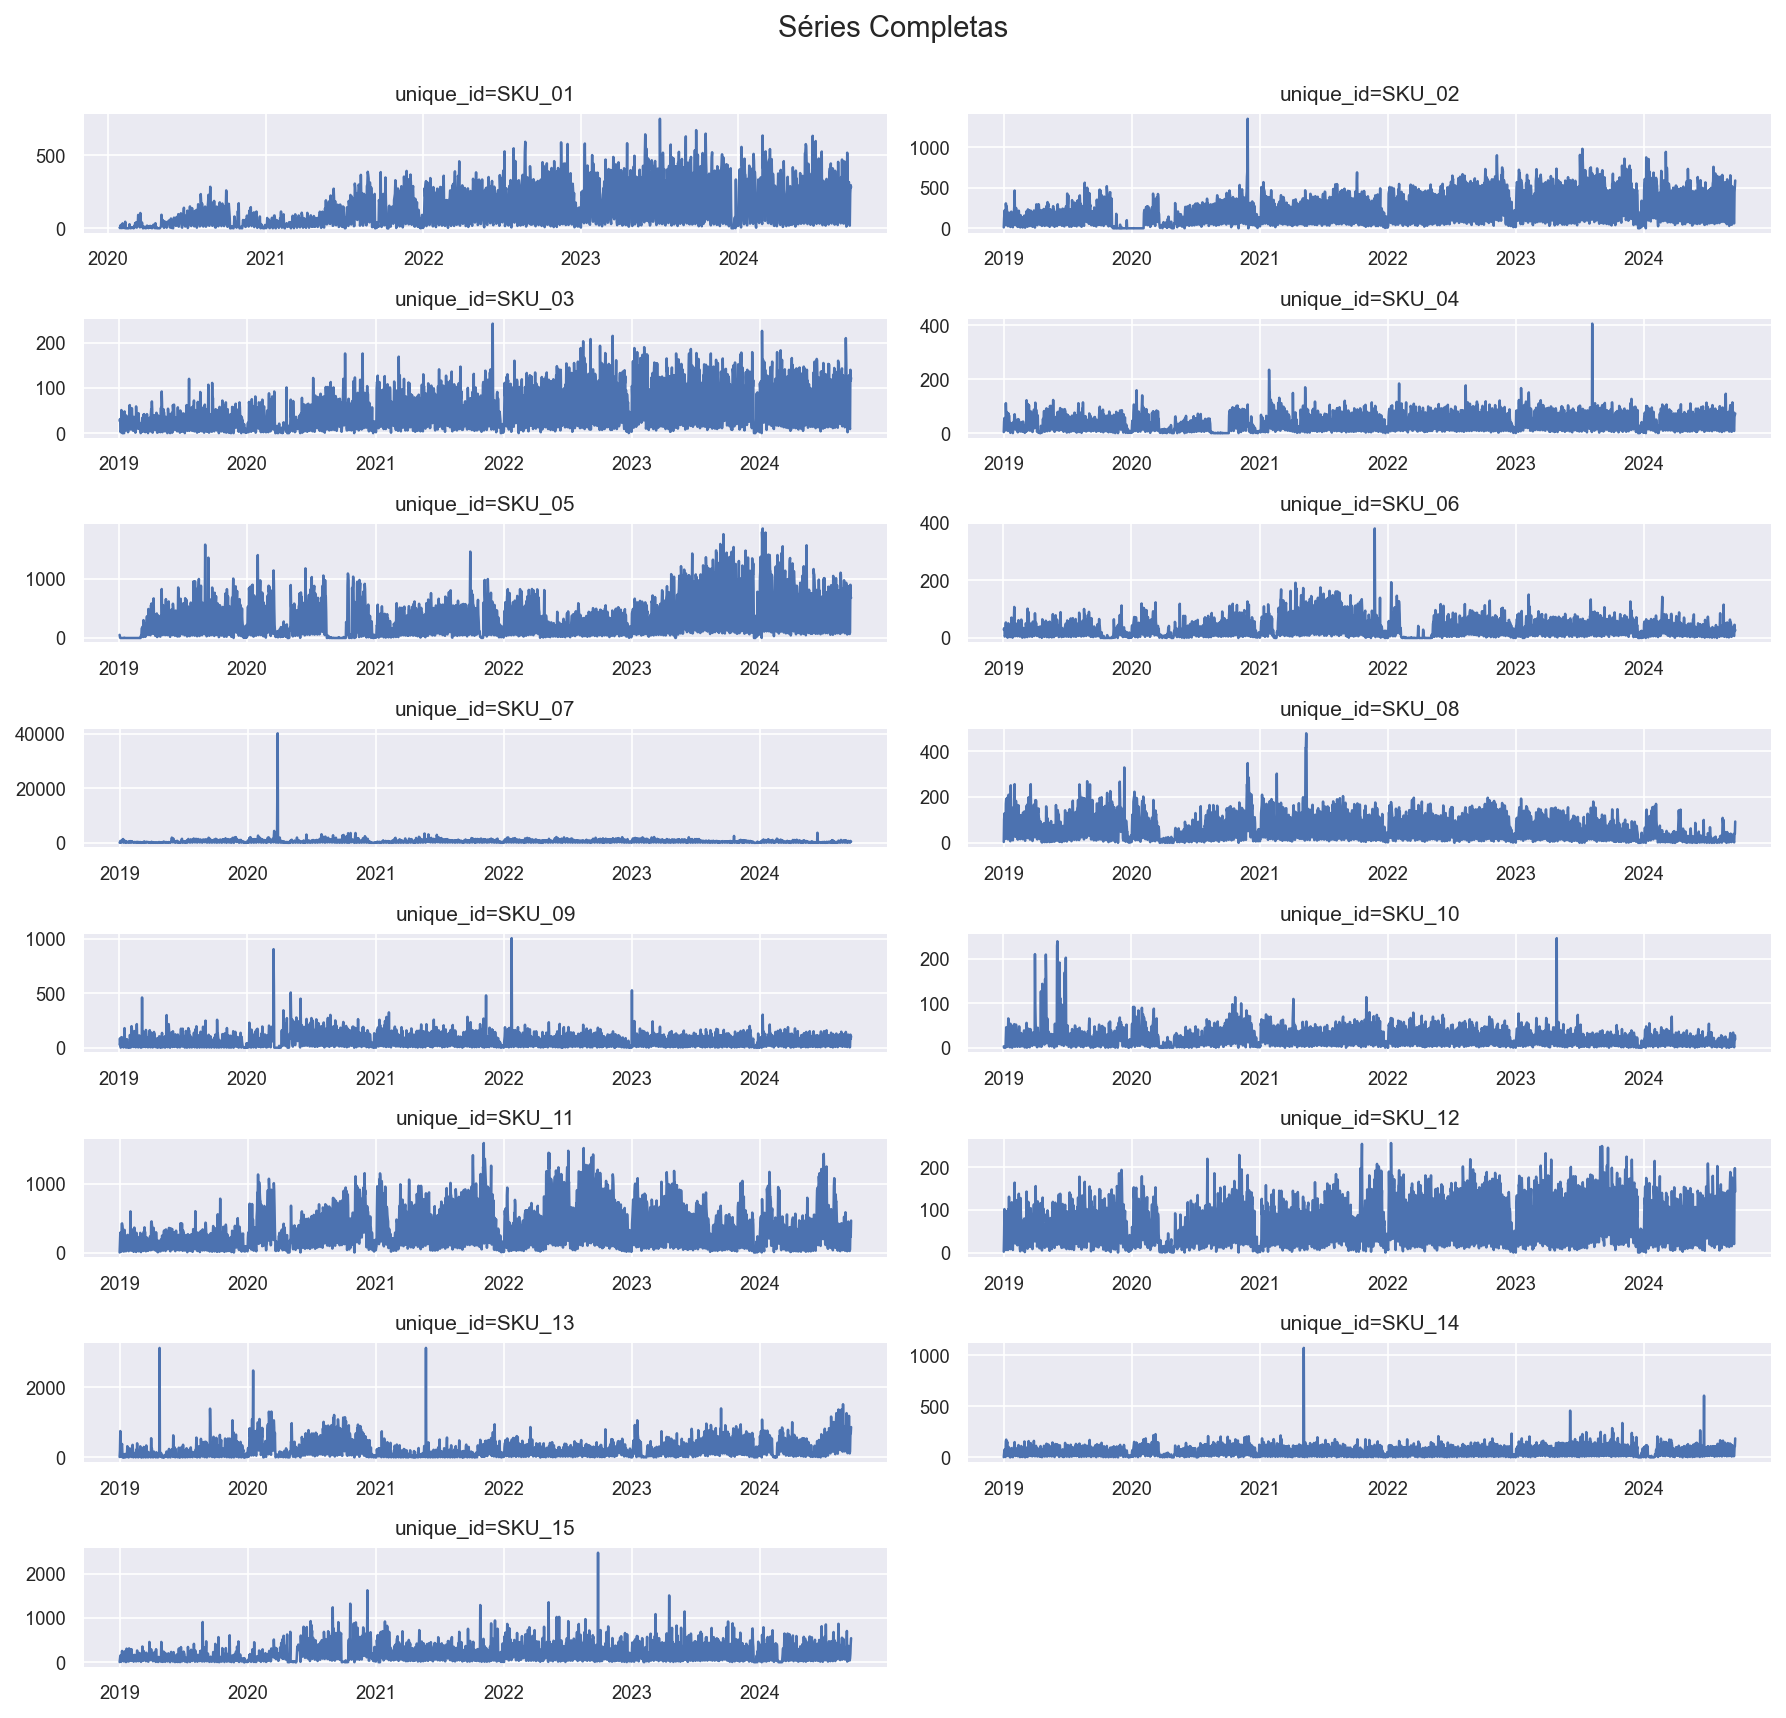

In [5]:
# plot das séries temporais completas
fig1 = plot_time_series(
    df=df,
    data_cols=['y'],
    figsize=(12, 12),
    title='Séries Completas'
)

### **Últimos 200 registros**
Visualização dos últimos 200 registros para identificar detalhadamente aspectos de sazonalidade não possíveis de visualizar no plot anterior. 

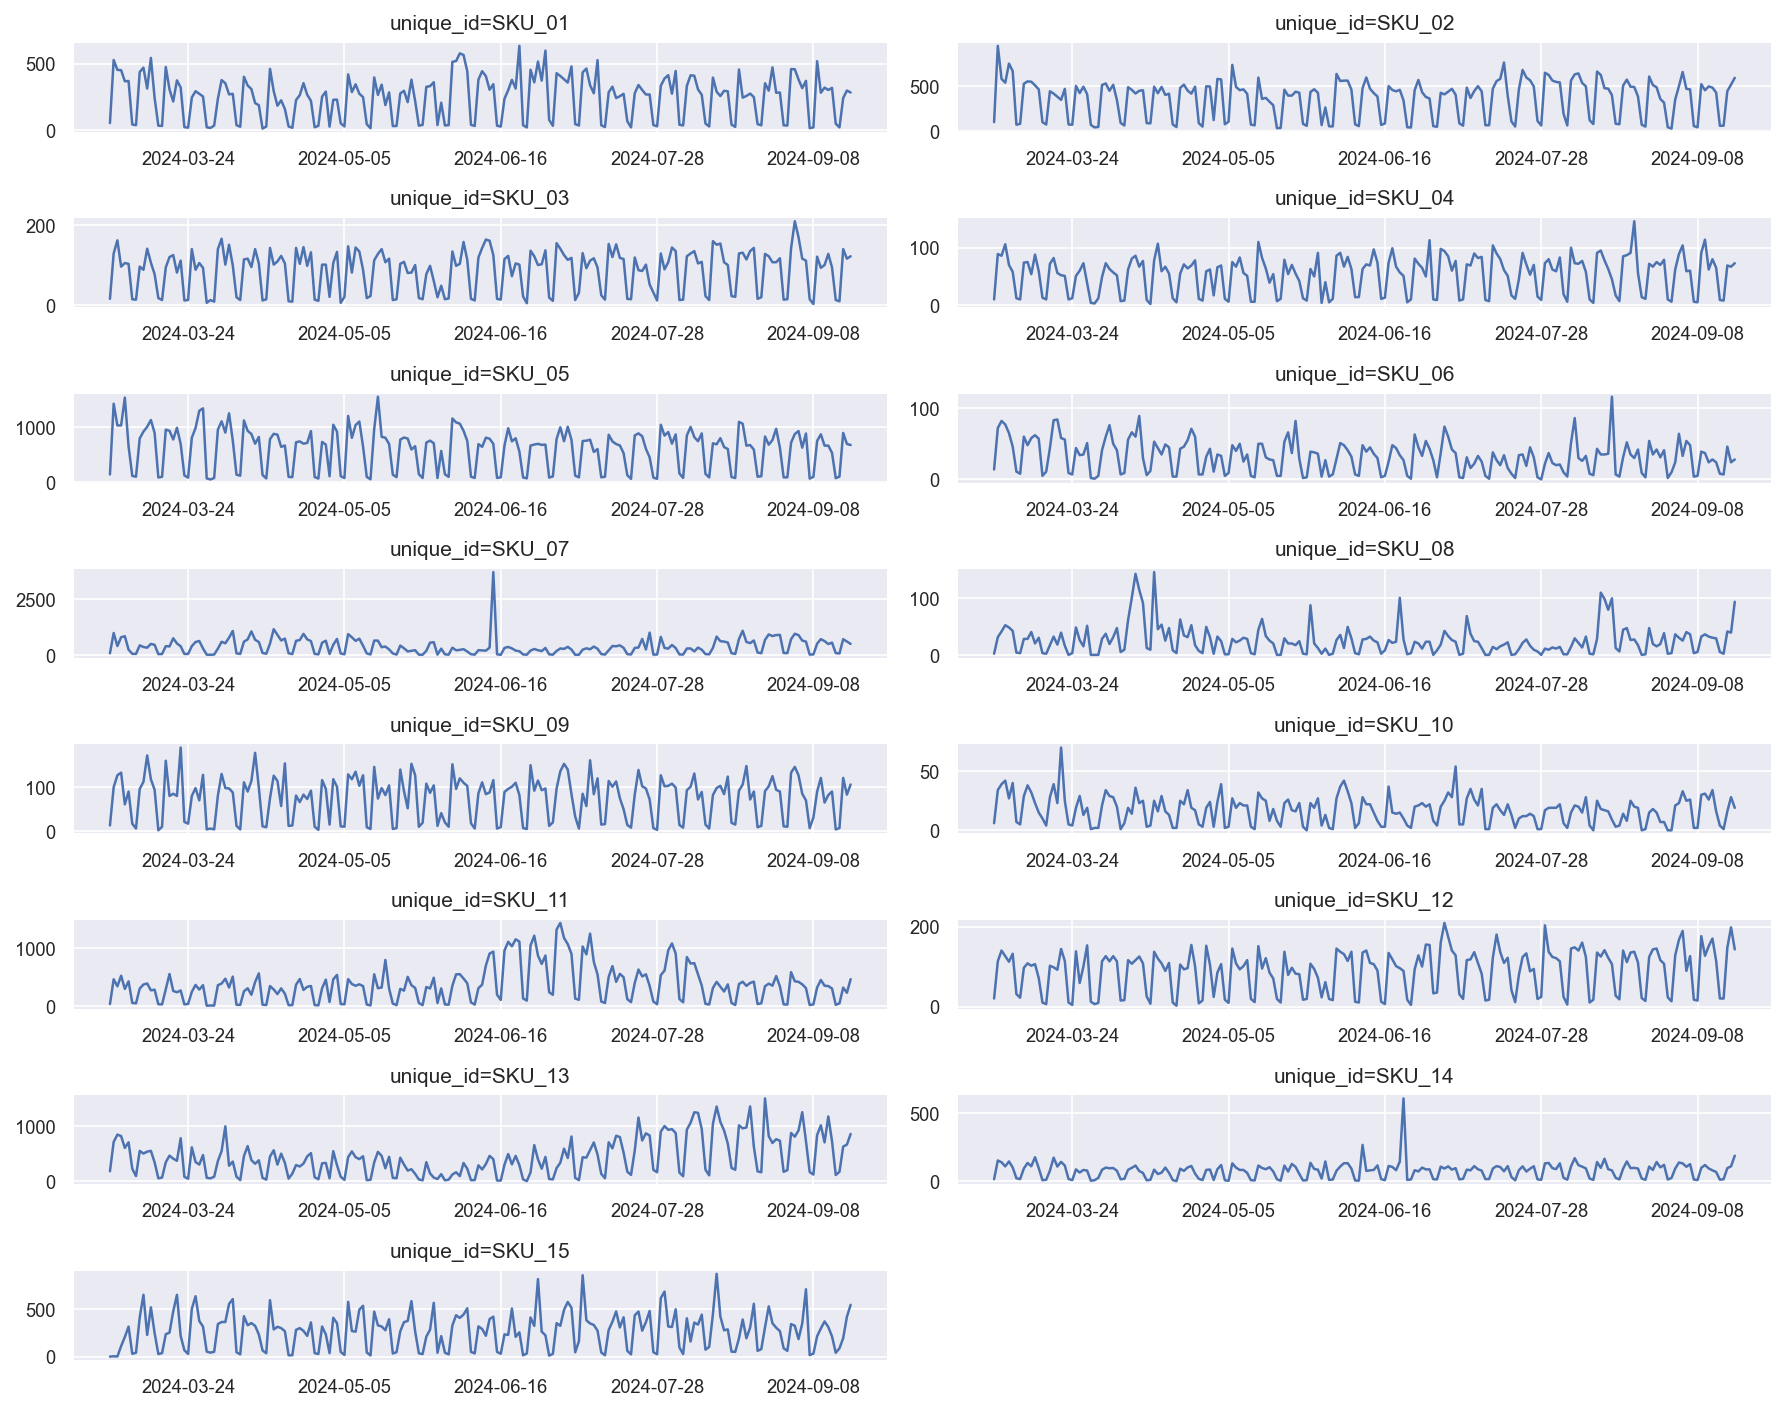

In [6]:
# plot os últimos 200 registros de cada série temporal
fig2 = plot_time_series(
    df=df,
    data_cols=['y'],
    grid=(8, 2),
    figsize=(12, 10),
    n_max=200
)

## **Decomposição das Séries**
Séries temporais podem ser decompostas em padrões ou componentes separados, como tendência (podendo ser linear ou não), sazonalidade (ciclos que se repetem a cada semana, mês ou ano, por exemplo), de modo que uma série temporal pode ser definida pela seguinte forma:
$$
y_t = T_t + S_t + R_t
$$

onde $y_t$ é valor observado, $T_t$ é a tendência $S_t$ é o componente sazonal, $R_t$ é o resíduo, todos observados no tempo $t$.


In [7]:
# decompondo as séries
decomposed_df = decompose(df)

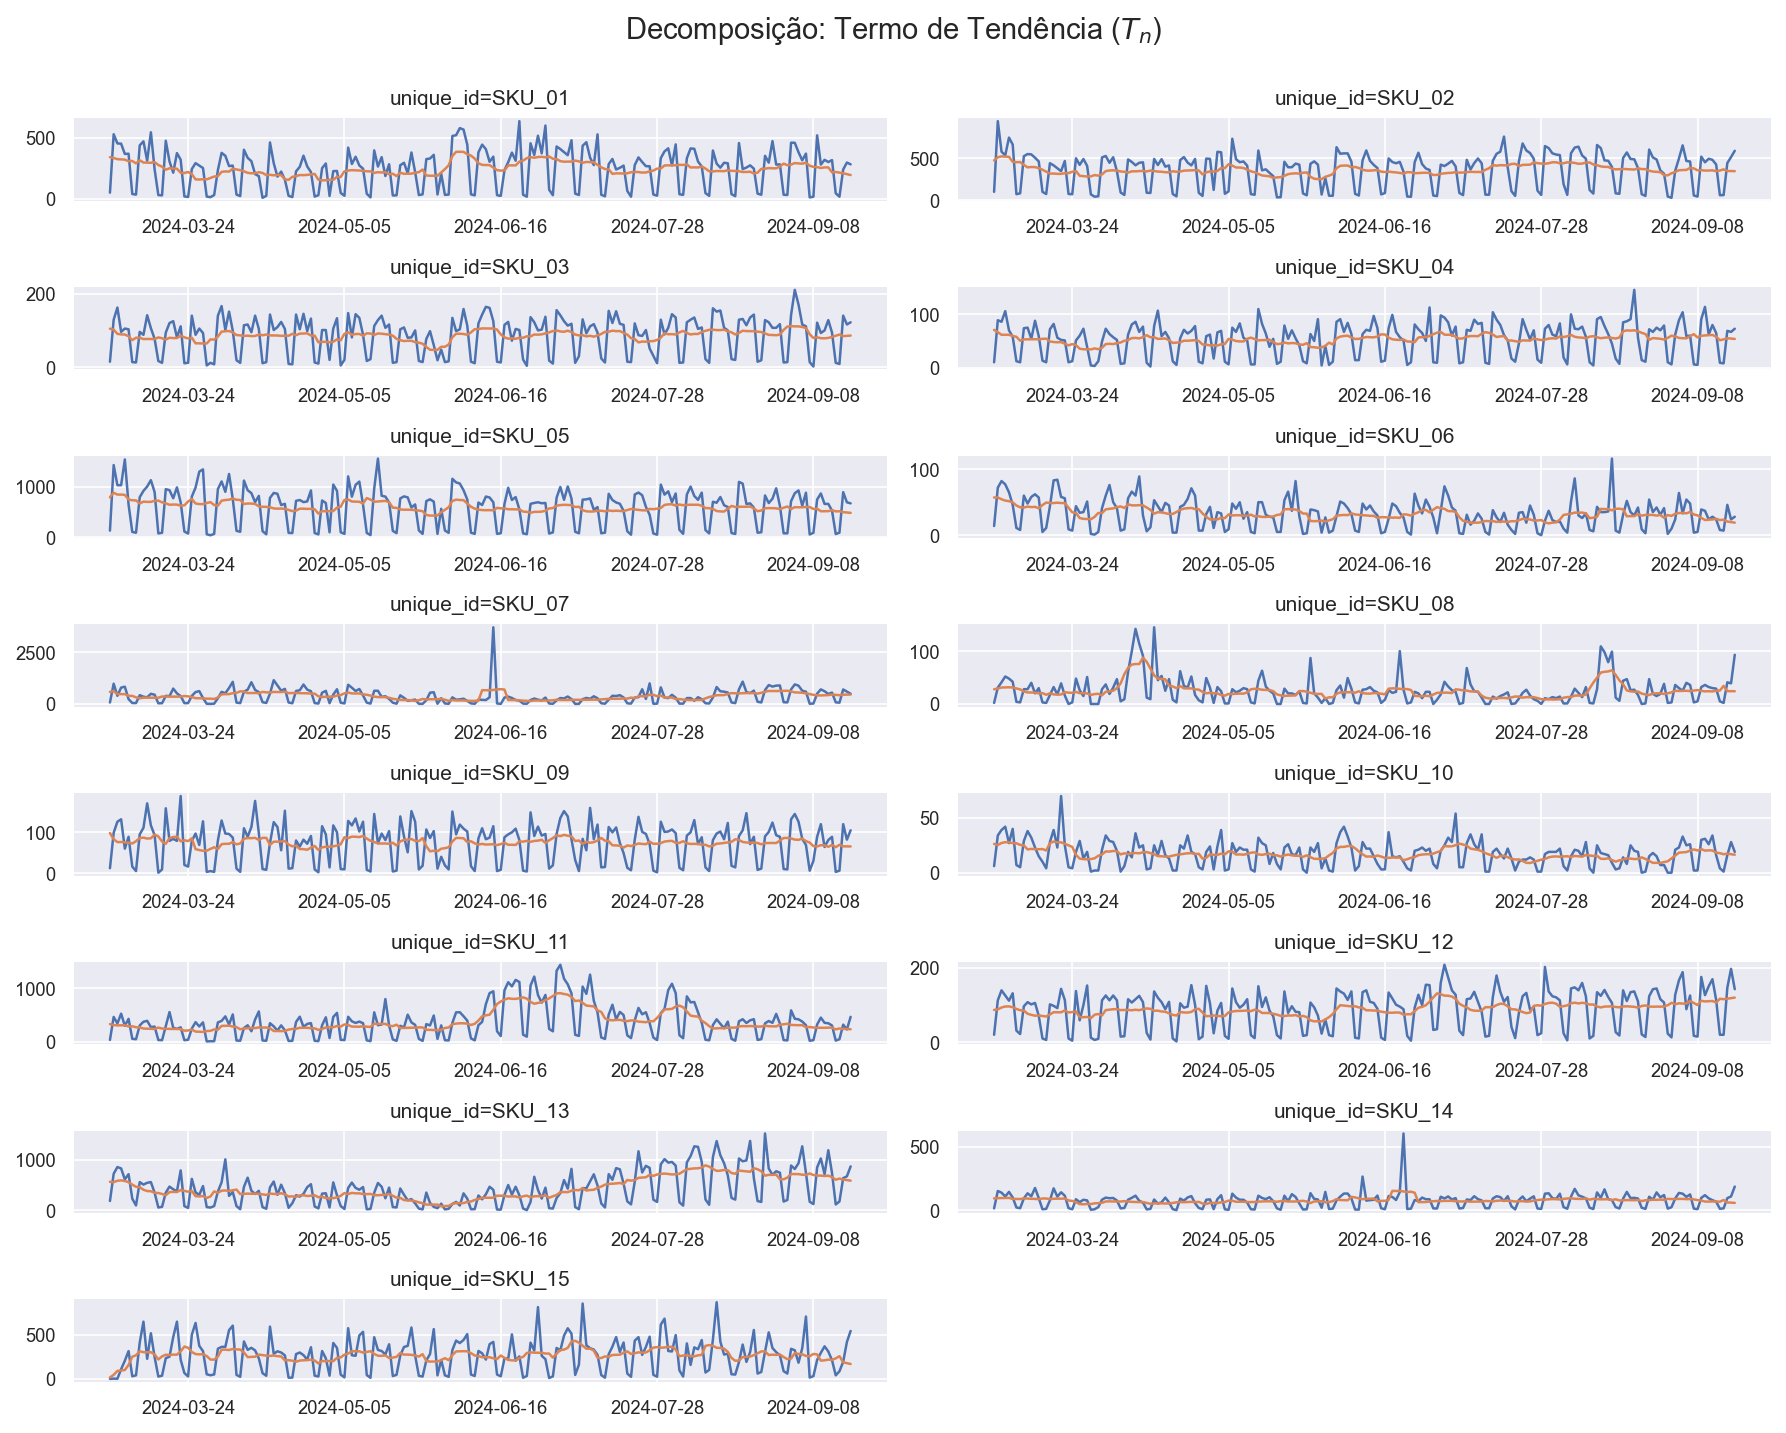

In [8]:
# plot das séries com a tendência baseada em média móvel
fig3 = plot_time_series(
    df=decomposed_df,
    data_cols=['y', 'trend'],
    figsize=(12, 10),
    n_max=200,
    title='Decomposição: Termo de Tendência ($T_n$)'
)

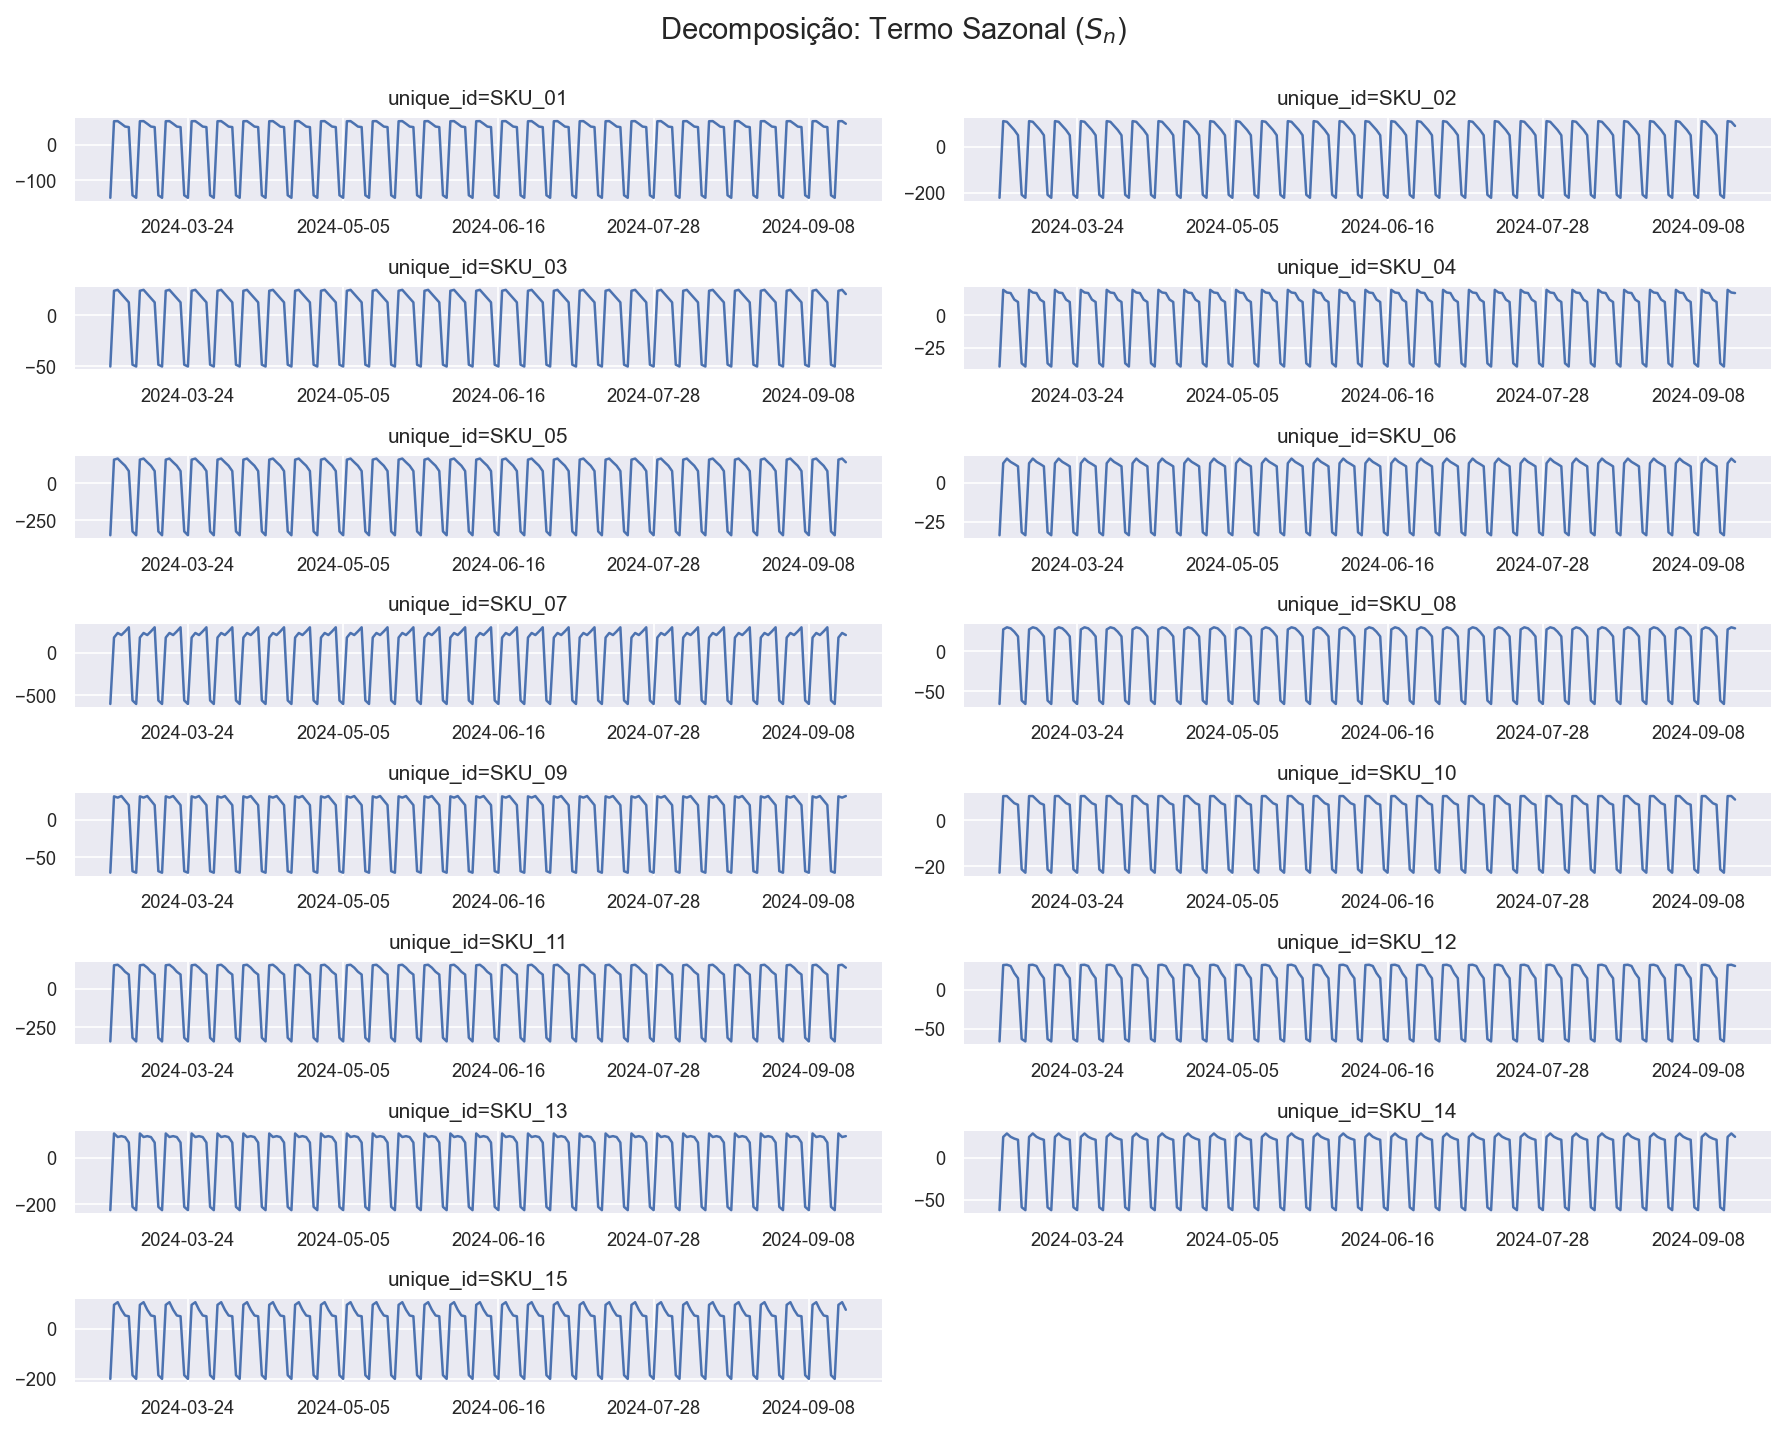

In [9]:
# plot do termo sazonal da série
fig4 = plot_time_series(
    decomposed_df,
    data_cols=['seasonal'],
    figsize=(12, 10),
    n_max=200,
    title='Decomposição: Termo Sazonal ($S_n$)'
)

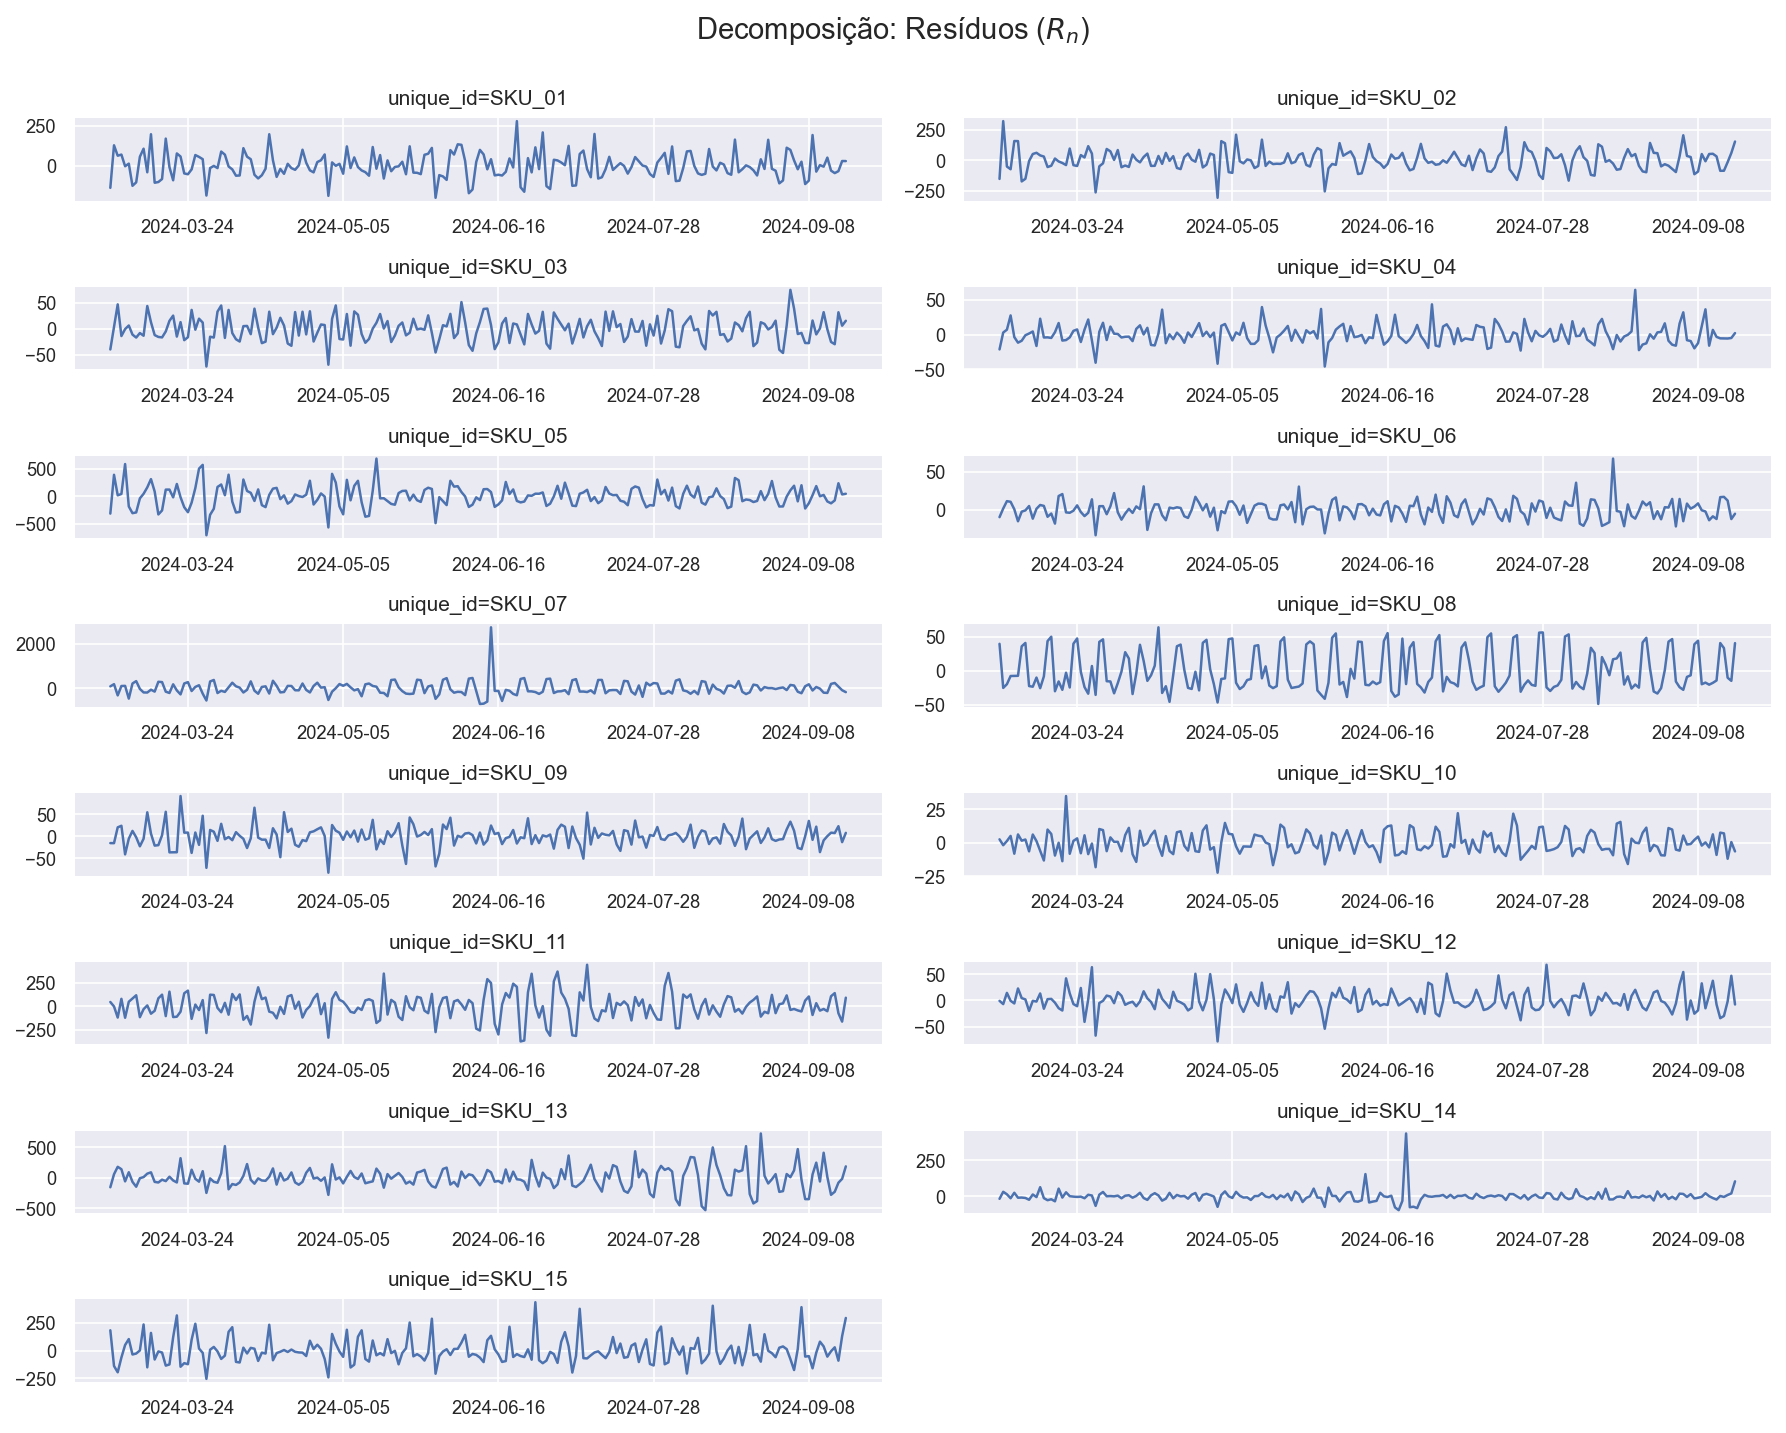

In [10]:
# plot dos resíduos da decomposição
fig5 = plot_time_series(
    decomposed_df,
    data_cols=['resid'],
    figsize=(12, 10),
    n_max=200,
    title='Decomposição: Resíduos ($R_n$)'
)

## **ACF: Função de Autocorrelação**
A função de autocorrelação mede a relação linear entre a série $y_t$ e seus valores defasados, de modo que observando seus resultados podemos identificar padrões de tendência e sazonalidade.

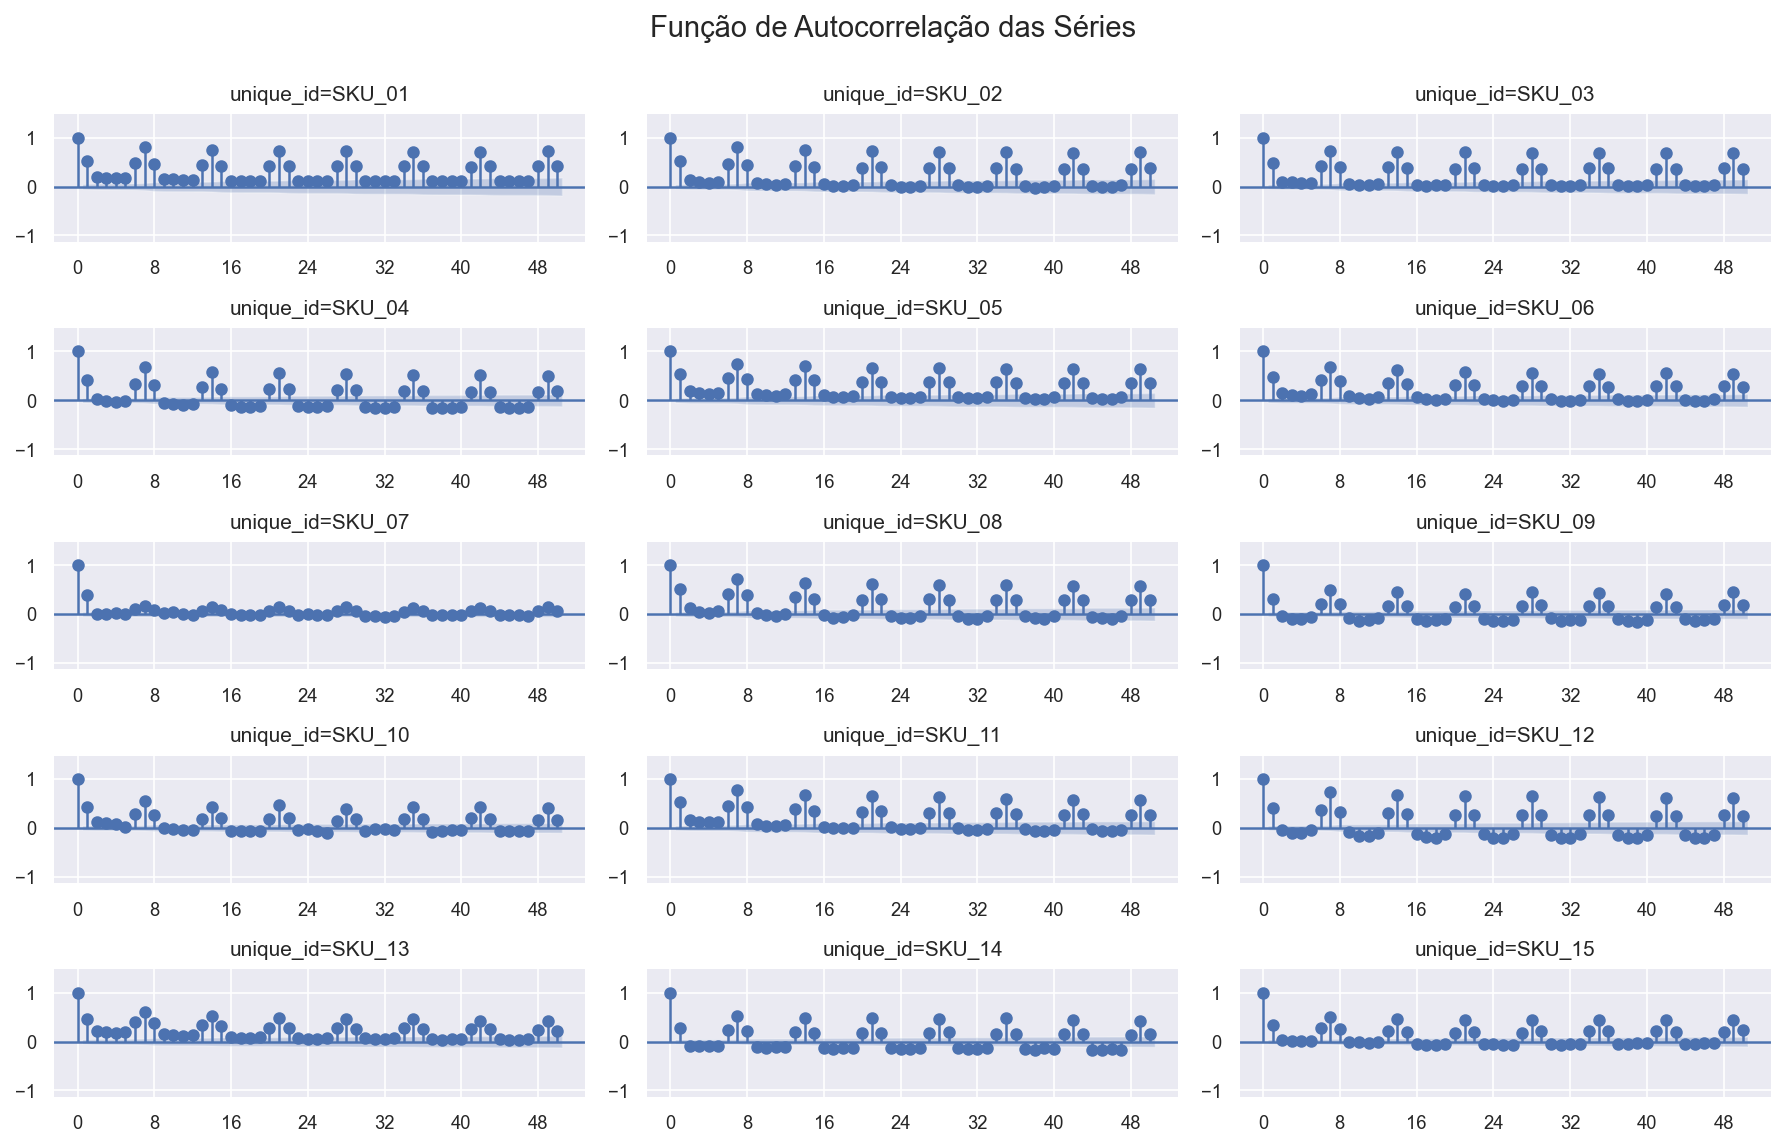

In [11]:
fig6 = plot_time_series_acf(
    df=df,
    target_col='y',
    max_lag=50,
    id_col='unique_id',
    title='Função de Autocorrelação das Séries',
    grid=(5, 3),
    figsize=(12, 8)
)

## **Dados de Treino e Teste**
Para os experimentos, serão utilizados 80% de cada série para treinar os modelos, e o restante dos dados para avaliar suas performances.

In [12]:
# dividindo dados em treino e teste
train_df, test_df = ts_train_test_split(df=df, train_size=0.8, id_col='unique_id')

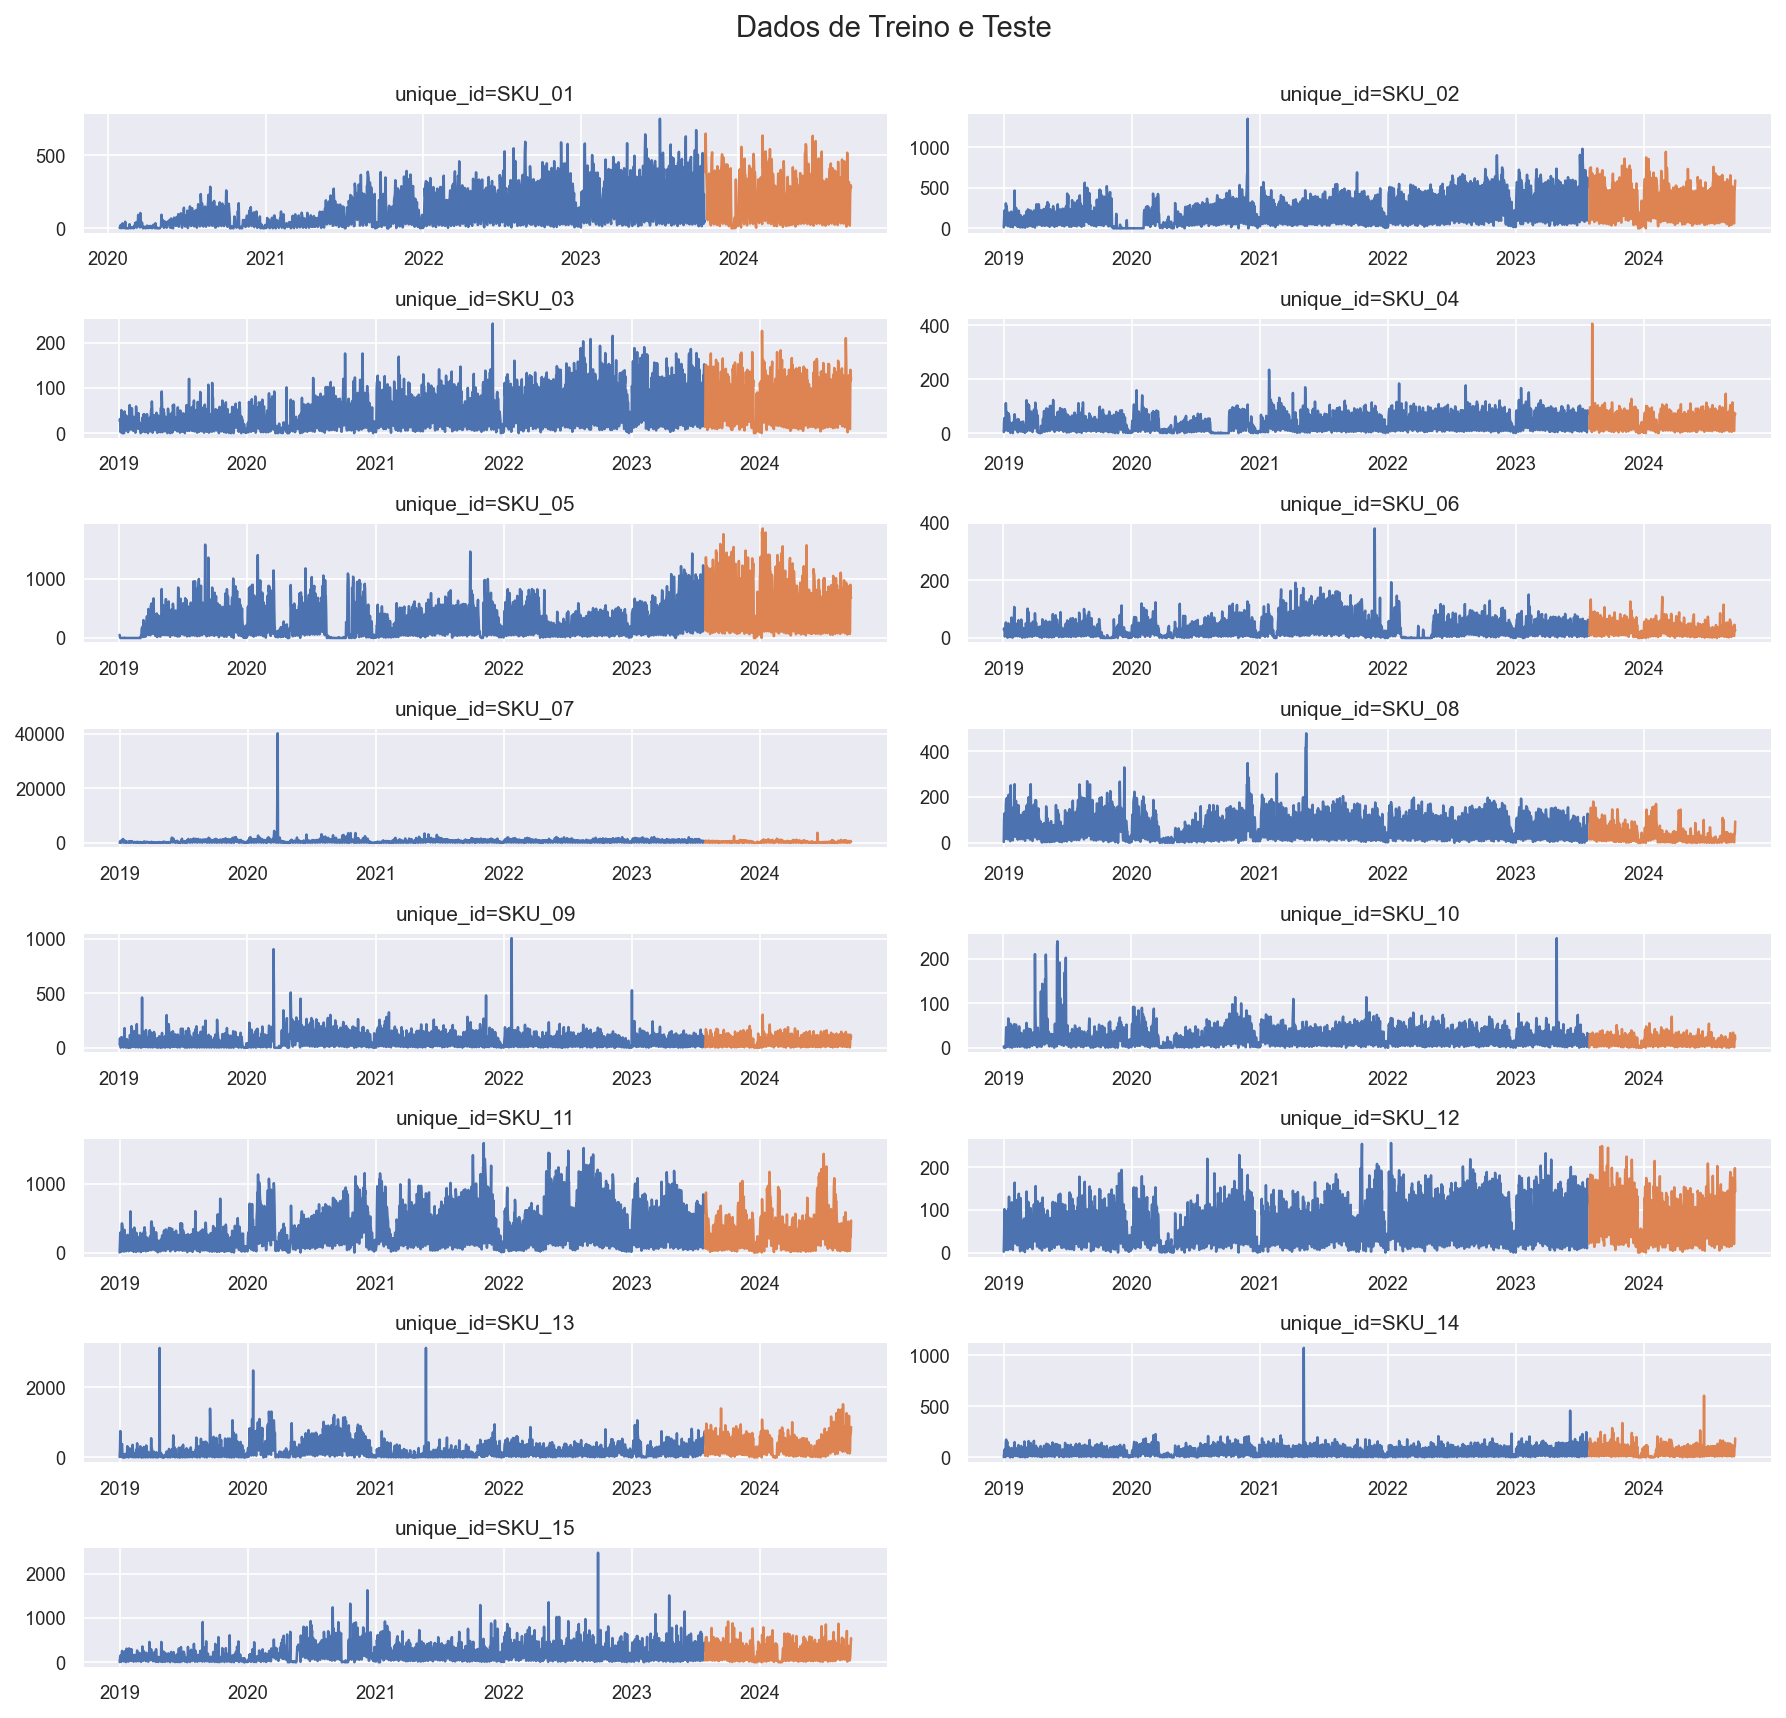

In [13]:
# visualizando split
fig7 = plot_time_series(
    df=train_df.merge(test_df, how='outer', on=['unique_id', 'ds'], suffixes=['_train','_test']),
    data_cols=['y_train', 'y_test'],
    title='Dados de Treino e Teste'
)

## **Outliers**
Para identificação e tratamento de outliers em séries temporais existem diversas técnicas, como identificação visual ou $1.5*IQR$. Aqui, utilizaremos o método de ESD (extreme Studentized deviate) [[1]](https://www.itl.nist.gov/div898/handbook/eda/section3/eda35h3.htm), que aplica teste de Grubbs [[2]](https://www.itl.nist.gov/div898/handbook/eda/section3/eda35h1.htm) sequencialmente até que o critério de parada ($G < $ *Região Crítica* | $\alpha$) seja atingido.
Serão aplicados os testes para valores mínimos e máximos nos resíduos da decomposição das séries temporais, seguindo a proposta do modelo **Seasonal-ESD** em **_Automatic Anomaly Detection in the Cloud
 Via Statistical Learning_** [[3]](https://arxiv.org/abs/1704.07706).
 
 Os resultados serão usados como inputs para os modelos como variáveis explicativas (**_max_outliers_** e **_min_outliers_**), onde 1 equivale a valores considerado outliers e 0 valores normais.
 Para os dados de teste, todos os valores serão marcados como 0, evitando vazamento de informação.

In [14]:
# detecção de outliers usando Seasonal-ESD
outliers_df = detect_outliers(df=train_df)
outliers_df.filter(like='outliers').sum()

max_outliers   186.00
min_outliers   110.00
dtype: float64

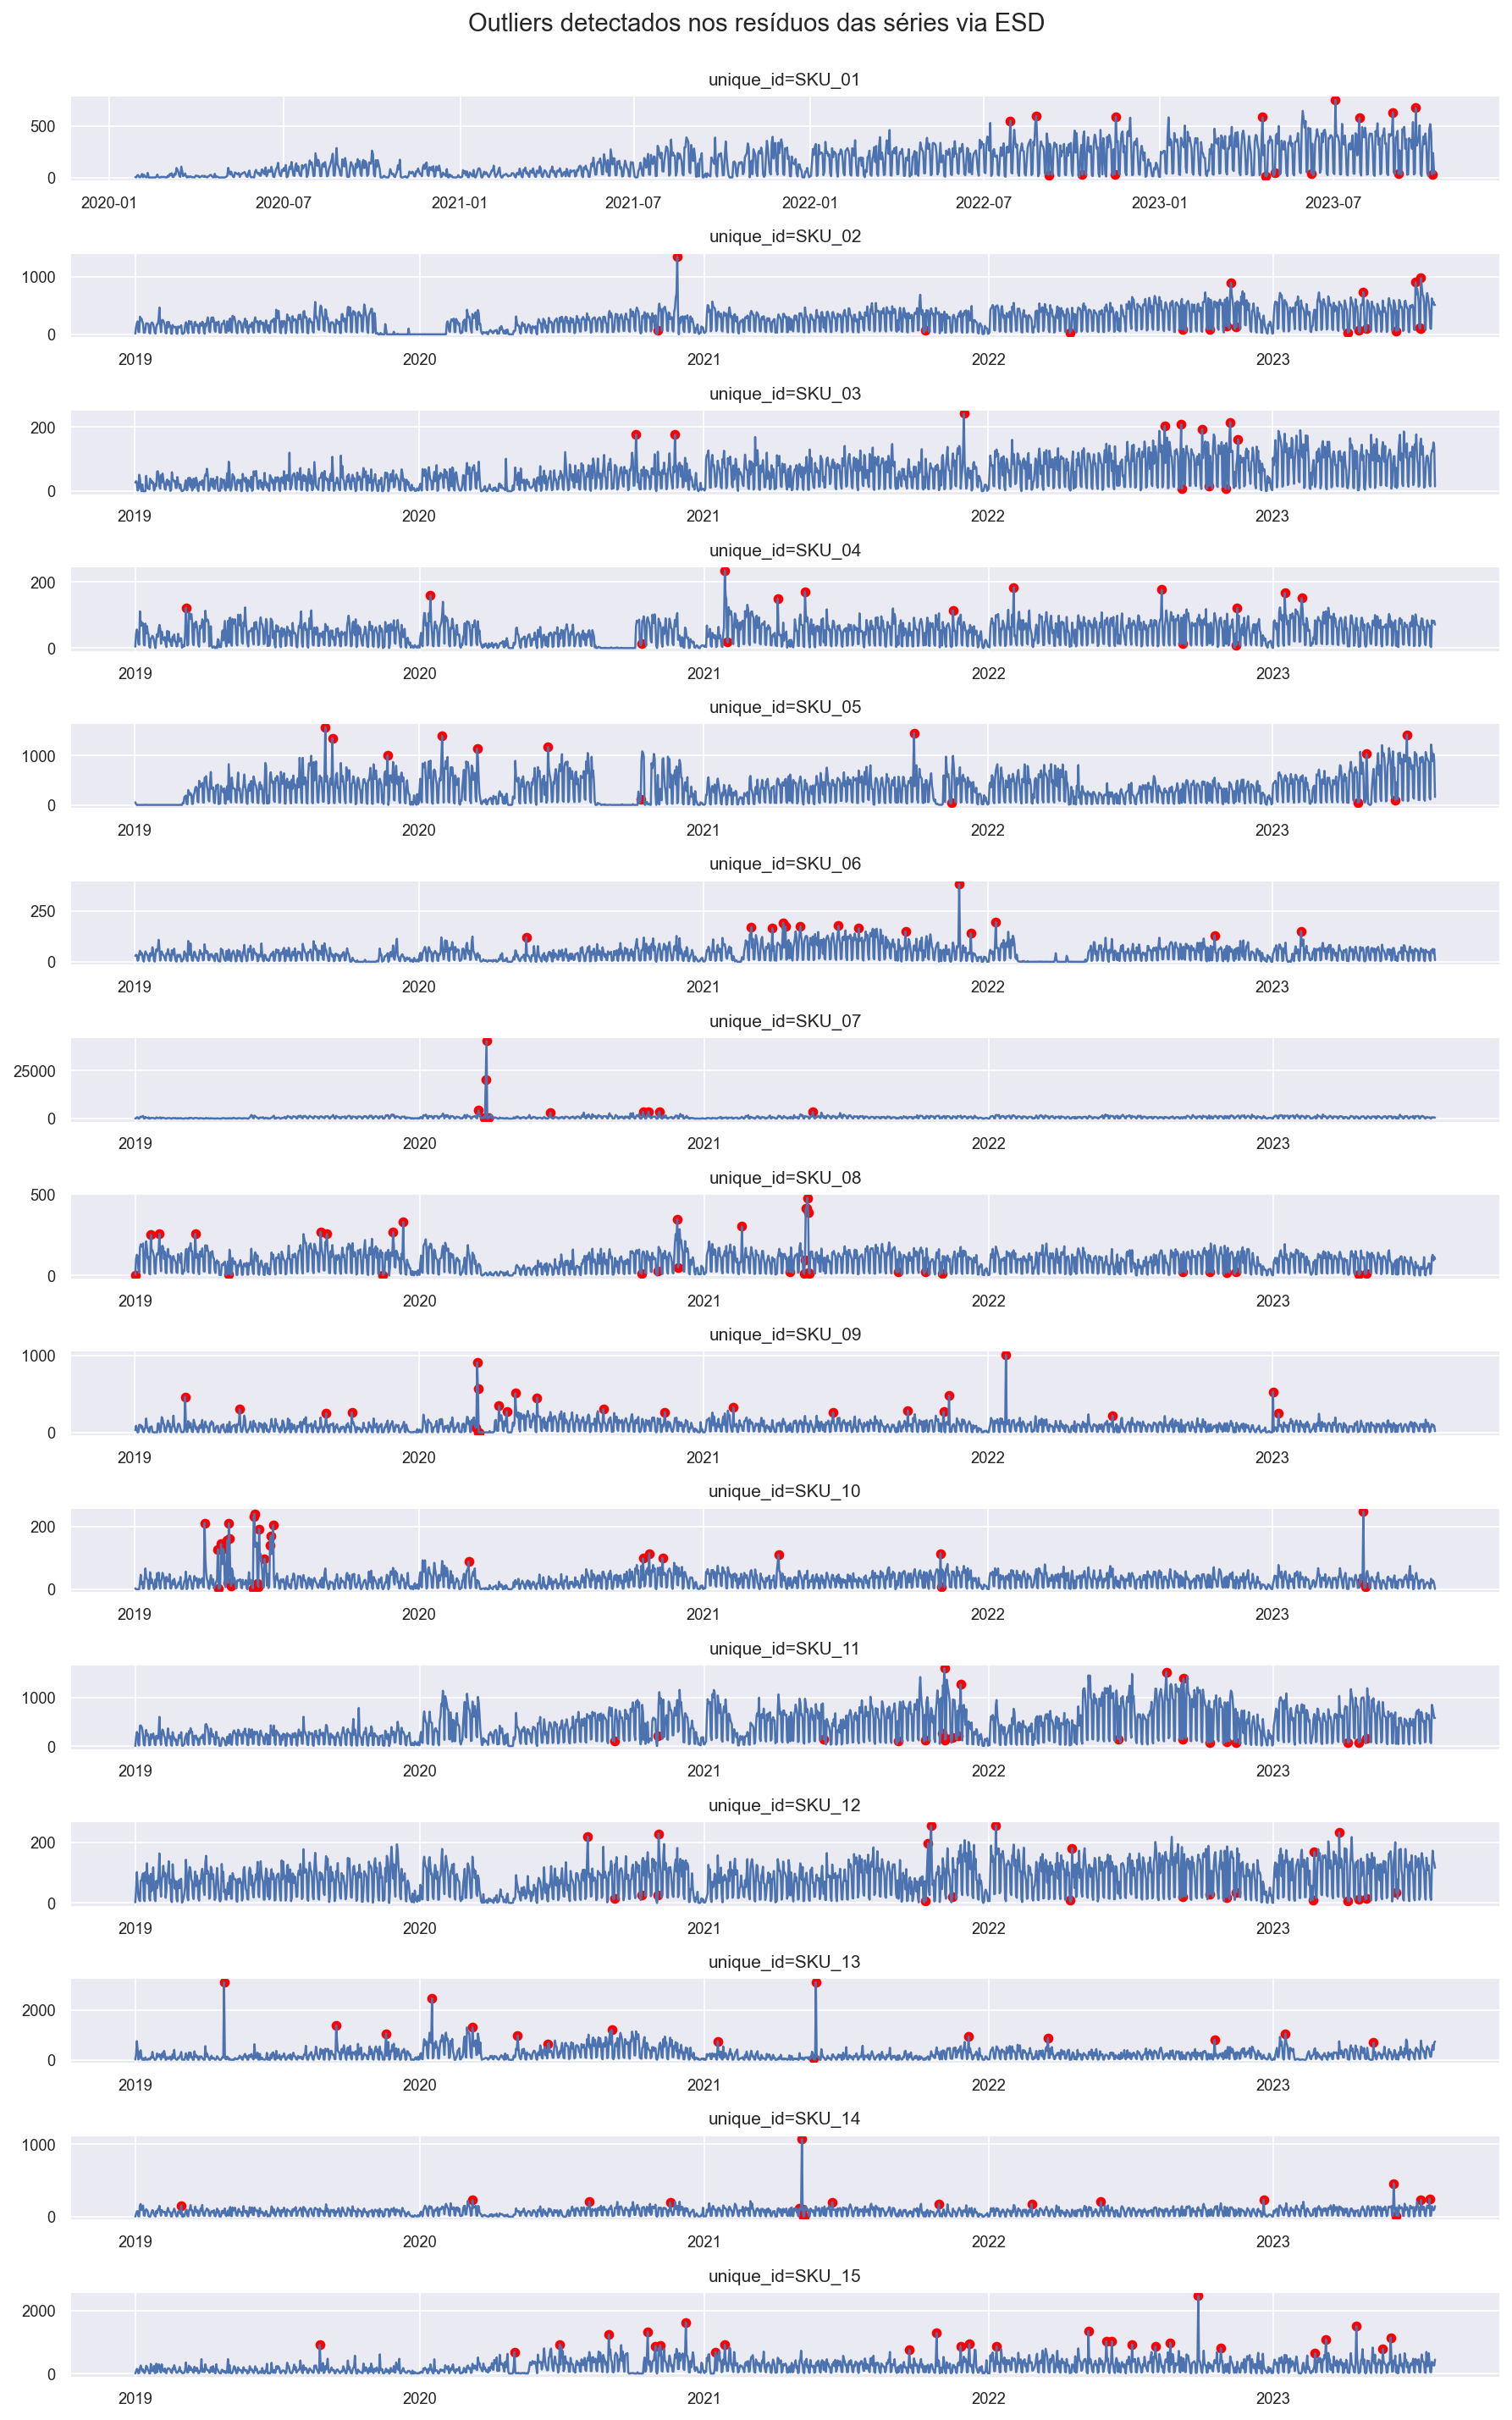

In [15]:
outliers_fig = plot_time_series(
    df=outliers_df, outliers_cols=['max_outliers', 'min_outliers'],
    grid=(15, 1),
    figsize=(12, 20),
    title='Outliers detectados nos resíduos das séries via ESD'
)

## **Salvando os Dados**

In [16]:
# salvando dados
train_df.to_csv("data/train_df.csv", index=False)
test_df.to_csv("data/test_df.csv", index=False)